# **The story**

## 0. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from rubix.run import run, run_grid
from rubix.constants import DATA_V1

In [2]:
# def main(
#     path_: str
# ) -> None:
    
#     """
#     Executes the optimization routine.

#     This function prepares the input data, initializes the solver, and executes
#     the optimization process. It accepts arbitrary keyword arguments, which may
#     include optional parameters for the solver or runtime configuration.

#     Expected kwargs:
#         path (str): Optional path to the input dataset. Defaults to DATA_V1.

#     Returns:
#         None
#     """
#     config_path = f"../rubix.configs/{path_}"

#     # Load the data from the provided path
#     dataset = load_data(
#         path=DATA_V1,
#         config_path = config_path
#     )

#     # Process the data to the necessary shape
#     dataset = process_data(dataset)
    
#     print(dataset)
    
#     # Initialize the solver
#     solver = Solver(
#         dataset.matrix, 
#         dataset.cost_params,  
#         dataset.layout_params, 
#         dataset.solver_params
#     )

#     # Solve the problem
#     result = solver.solve()

#     return dataset, result

In [ ]:
POP_SIZE = 50
# Will save the fitness of the best individual in the end of each of the 30 runs
rand_best_fitnesses = []
hc_best_fitnesses = []
sa_best_fitnesses = []
ga_best_fitnesses = []
rs_best_fitnesses = []

for run_nr in range(3):
    # Random Search
    dataset, result, history = run(
        data_path=DATA_V1
        ,config_file='random_search_config.json'
    )
    rand_best_fitnesses.append(result.rubix_fitness.item())

    # Hill Climbing
    dataset, result, history = run(
        data_path=DATA_V1
        ,config_file='hill_climber_config.json'
    )
    hc_best_fitnesses.append(result.rubix_fitness.item())

    # Annealer
    dataset, result, history = run(
        data_path=DATA_V1
        ,config_file='annealing_config.json'
    )
    sa_best_fitnesses.append(result.rubix_fitness.item())

    # Genetic
    dataset, result, history = run(
        data_path=DATA_V1
        ,config_file='genetic_config.json'
    )
    ga_best_fitnesses.append(result.rubix_fitness.item())

    # Rubix Search
    dataset, result, history = run(
        data_path=DATA_V1
        ,config_file='rubix_search_config.json'
    )
    rs_best_fitnesses.append(result.rubix_fitness.item())

DataSet(
  stage: Processed,

  dataframe:
              Name Position  Skill  Salary (â‚¬M)
0      Alex Carter       GK     85             90
1     Jordan Smith       GK     88            100
2    Ryan Mitchell       GK     83             85
3   Chris Thompson       GK     80             80
4  Blake Henderson       GK     87             95

  constructors:
    label_col: 'Position'
    weights: ['Skill', 'Salary (â‚¬M)']
    constraints: {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2}
    window: []

  solver parameters:
    strategy: 'random'
    n: 100
    n_iter: 15

  matrix:
tensor([[ 0,  5, 10, 15, 20, 25, 30],
        [ 1,  6, 11, 16, 21, 26, 31],
        [ 2,  7, 12, 17, 22, 27, 32],
        [ 3,  8, 13, 18, 23, 28, 33],
        [ 4,  9, 14, 19, 24, 29, 34]])

  layout parameters:
    block_indices: [0, 1, 3, 5]
    block_ranges: [(0, 1), (1, 3), (3, 5), (5, 7)]
    n_cols: 5
    n_rows: 7
    n_layers: 100
    window: (5, 7)
    rubix_shape: (100, 5, 7)

  cost parameters:
    arrays

KeyboardInterrupt: 

In [ ]:
# Create a DataFrame in long format
df = pd.DataFrame({
    'value': rand_best_fitnesses + hc_best_fitnesses + sa_best_fitnesses + ga_best_fitnesses + rs_best_fitnesses,
    'group':   
        ['Random Search'] * len(rand_best_fitnesses) + 
        ['Hill Climber'] * len(hc_best_fitnesses) + 
        ['Annealing'] * len(sa_best_fitnesses) + 
        ['Genetic'] * len(ga_best_fitnesses) +
        ['Rubix Search'] * len(rs_best_fitnesses)
})

# Set a beautiful theme
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='group', y='value', data=df, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Fitness Comparison for Optimization Algorithms', fontsize=16)
plt.xlabel('Algorithms')
plt.ylabel('Fitness of best found individual')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
run_grid(
        data_path=DATA_V1
        ,config_file='random_search_config.json'
        ,dynamic_params={
            'n_iter': 15
        }
    )

In [ ]:
POP_SIZE = 100
GENERATIONS = 200

grid_params = {
    "crossover": [{
            "x_strategy": "slice_crossover",
            "p_cross": 0.8
        }
        # , {
        #     "x_strategy": "cube_crossover",
        #     "xo_prob": 0.8
        # }
    ],
    # "mutation": [{
    #         "function": swap_mutation,
    #         "mut_prob": 0.8
    #     },
    #     {
    #         "function": inversion_mutation,
    #         "mut_prob": 0.2
    #     }
    # ],
    "elitism": [{
        "elitism": 1
    }, {
        "elitism": 0
    }]
}

fitness_dfs = {}

# Generate all combinations of the grid parameters
grid = list(
    itertools.product(
        grid_params["crossover"]
        # ,grid_params["mutation"]
        ,grid_params["elitism"]
    )
)

for crossover_cfg, elitism in grid:
    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS))  # Shape will be max(run_nr) + 1 x GENERATIONS

    config_results = []

    # Run for 30 times
    for run_nr in range(30):
        _, _, fitness_over_gens = run_grid(
            data_path=DATA_V1
            ,config_file='genetic_config.json'
            ,dynamic_params=crossover_cfg | elitism
        )
        config_results.append(fitness_over_gens)

        # df.loc[run_nr] = fitness_over_gens

        padded_fitness = fitness_over_gens + [float('inf')] * (GENERATIONS - len(fitness_over_gens))

        # Now assign
        df.loc[run_nr] = padded_fitness

    # Create a label for the configuration
    config_label = (
        f"{crossover_cfg["x_strategy"]}{crossover_cfg["p_cross"]}_"
        f"mutation_configs_missing_elitism={elitism["elitism"]}"
    )

    # Save configuration results in the dictionary
    fitness_dfs[config_label] = df


DataSet(
  stage: Processed,

  dataframe:
              Name Position  Skill  Salary (â‚¬M)
0      Alex Carter       GK     85             90
1     Jordan Smith       GK     88            100
2    Ryan Mitchell       GK     83             85
3   Chris Thompson       GK     80             80
4  Blake Henderson       GK     87             95

  constructors:
    label_col: 'Position'
    weights: ['Skill', 'Salary (â‚¬M)']
    constraints: {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2}
    window: []

  solver parameters:
    strategy: 'genetic'
    n: 100
    n_pairs: 50
    epochs: 200
    patience: 50
    select_type: 'tournament'
    vs_type: 'probabilistic'
    x_strategy: 'slice_crossover'
    vs_size: 2
    elitism: 1
    p_cross: 0.8
    p_mutation: 0.1
    p_roll: 0.5
    p_swap: 0.5

  matrix:
tensor([[ 0,  5, 10, 15, 20, 25, 30],
        [ 1,  6, 11, 16, 21, 26, 31],
        [ 2,  7, 12, 17, 22, 27, 32],
        [ 3,  8, 13, 18, 23, 28, 33],
        [ 4,  9, 14, 19, 24, 29, 34]])

 

In [7]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

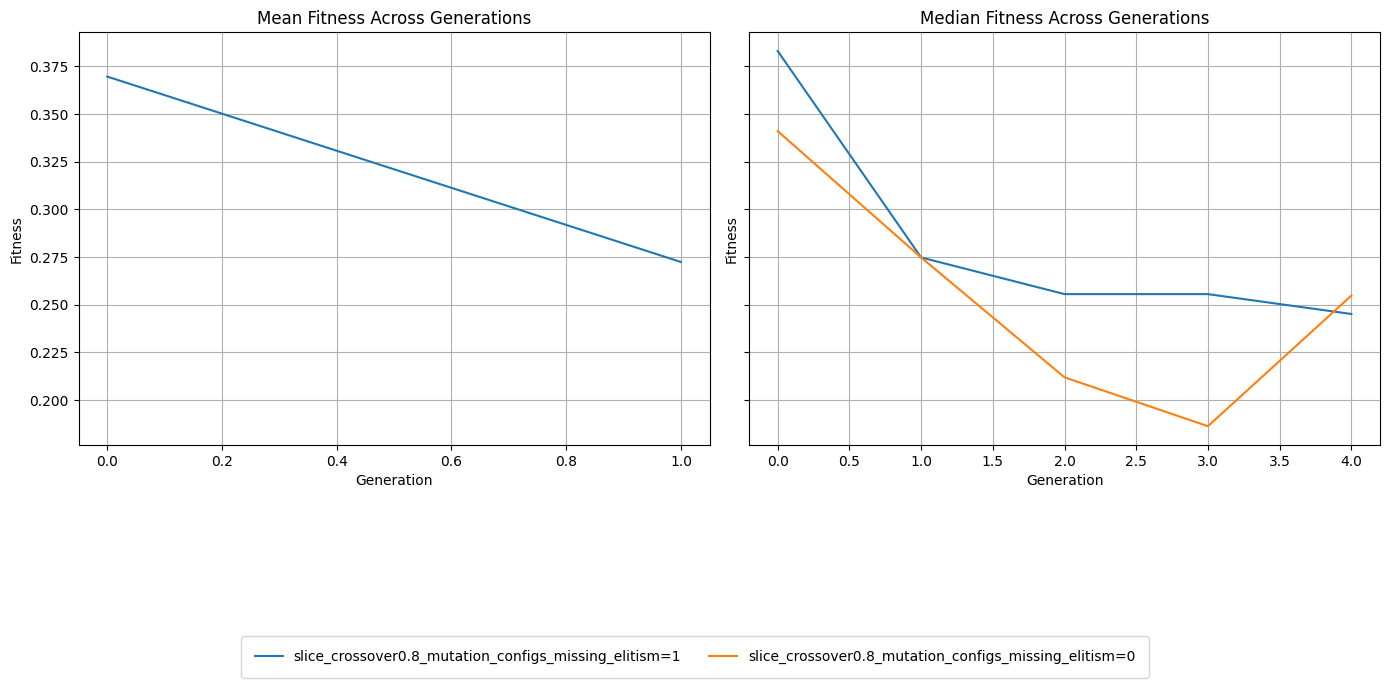

In [8]:
plot_fitness_over_gen(fitness_dfs)